# Spatiotemporal Evolution of Marine Heatwaves Globally

## Methods

### Data and Preprocessing

We analyze monthly global maps of SST from the 0.25º longitude by 0.25º latitude gridded Optimum Interpolation SST version 2.1 (OISSTv2.1) dataset that extends from September 1981 through June 2021. The OISSTv2.1 combines satellite Advanced Very High Resolution Radiometer (AVHRR-only) with observations from ship, buoy, and in situ measurements (including Argo floats and drifters), while accounting for platform differences and using interpolations to fill gaps in the satellite data (Reynolds et al., 2002; 2007).

In [101]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

from joblib import Parallel, delayed
import pickle

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

import warnings
warnings.filterwarnings('ignore')

In [102]:
# Import NOAA OISST v2.1 dataset and resample to monthly means
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta=True).resample(time='MS').mean()
print(ds)

<xarray.Dataset>
Dimensions:  (time: 478, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * zlev     (zlev) float32 0.0
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.

In [103]:
# Decimal Year
dyr = ds.time.dt.year + ds.time.dt.month/12
dyr = dyr[:473] # this is so that we only look at September 1981 through January 2021

In [104]:
# Load SST field
sst = ds.sst.isel(zlev=0).drop('zlev')[:473,:,:]
sst.load()

<xarray.DataArray 'sst' (time: 473, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.3066666, -1.3066666, -1.3073332, ..., -1.3066666,
         -1.3066666, -1.3063333],
        [-1.3096668, -1.31     , -1.31     , ..., -1.3093333,
         -1.3093333, -1.3096668],
        [-1.3119999, -1.3119999, -1.3119999, ..., -1.3119999,
         -1.3119999, -1.3119999]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.692258 , -1.7109675, -1.7212902, ..., -1.7280644,
         -1.7206451, -1.7009677],
        [-1.7170967, -1.7522581, -1.7719355, ..., -1.7693548,
         -1.7612906, -1.7274194],
        [-1.7999998, -1.7999998, -1.7999998, ..., -1.7999998,
         -1.7999998, -1.7999998]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7274193, -1.7429032, -1.7522581, ..., -1.7490321,
         -1.7438709, -1.7283869],
        [-1.7470968, -1.7690326, -1.7848389, ..., -1.7890326,
         -1.7783874, -1.7483871],
        [-1.7999997, -1.7999997, -1.7999997, ..., -1.7999997,
         -1.7999997, -1.7999997]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-01-01
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_max:  4500
    valid_min:  -300

We create a mask over the Arctic (>65ºN) and Antarctic (>70ºS) Oceans to remove data in these regions and to avoid influence from seasonal sea ice and where the OISSTv2.1 data are less reliable

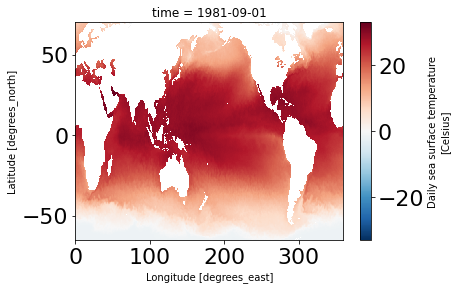

In [105]:
sst_nopoles = sst.sel(lat=slice(-65, 70)) # Mask over the Arctic (>65ºN) and Antarctic (>70ºS)
sst_nopoles[0,:,:].plot.imshow() # let's see if we did the mask correctly

In [106]:
sst_nopoles.shape

(473, 540, 1440)

In [107]:
SSTm = sst.mean(dim='time') # mean SST

In [108]:
SSTm_nopoles = xr.where((SSTm.lat>-65) & (SSTm.lat<70), SSTm, np.nan)

onlypoles = xr.where((SSTm.lat<-65) | (SSTm.lat>70), SSTm, np.nan)
onlypoles = xr.where(onlypoles >=0, 1, onlypoles)
onlypoles = xr.where(onlypoles <0, 1, onlypoles)

In [109]:
newnew = xr.where((SSTm.lat<-65) | (SSTm.lat>70), SSTm, np.nan)
newnew = xr.where(newnew <= 5, 1.,np.nan)

In [110]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':sst.lat.values, 'lon':sst.lon.values})

# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

# compute anomalies by removing all  the model coefficients 
ssta_notrend = sst-model_da.dot(sst_mod)

# Compute the monthly standard deviation
stdev = ssta_notrend.groupby(ssta_notrend.time.dt.month).std()

# Divide by standard deviation
ssta_stn_notrend = ssta_notrend.groupby(ssta_notrend.time.dt.month) / stdev

# Use the 90th percentile as a threshold and find anomalies that exceed it. 
if ssta_stn_notrend.chunks:
    ssta_stn_notrend = ssta_stn_notrend.chunk({'time': -1})

threshold = ssta_stn_notrend.quantile(.9, dim=('time'))
features_notrend = ssta_notrend.where(ssta_stn_notrend>=threshold, other=np.nan)

In [111]:
ssta_notrend_nopoles = xr.where((ssta_notrend.lat>-65) & (ssta_notrend.lat<70), ssta_notrend, np.nan)
print(ssta_notrend_nopoles.shape)

(720, 473, 1440)


In [112]:
ssta_notrend_std = ssta_notrend_nopoles.std(dim='time')
ssta_notrend_std_nopoles = xr.where((ssta_notrend_std.lat>-65) & (ssta_notrend_std.lat<70), ssta_notrend_std, np.nan)

In [113]:
seas_month = seas.groupby("time.month").mean(dim="time") # calculate each month temp everywhere

In [114]:
seas_max = seas_month[:,:,:].max(dim='month')
seas_min = seas_month[:,:,:].min(dim='month')
seas_amp = seas_max - seas_min

seas_amp_nopoles = xr.where((seas_amp.lat>-65) & (seas_amp.lat<70), seas_amp, np.nan)

In [115]:
trend_30yrs = trend.sel(time=slice('1990-01-01', '2020-12-01')).sum(dim='time')/30
trend_30yrs_nopoles = xr.where((trend_30yrs.lat>-65) & (trend_30yrs.lat<70), trend_30yrs, np.nan)

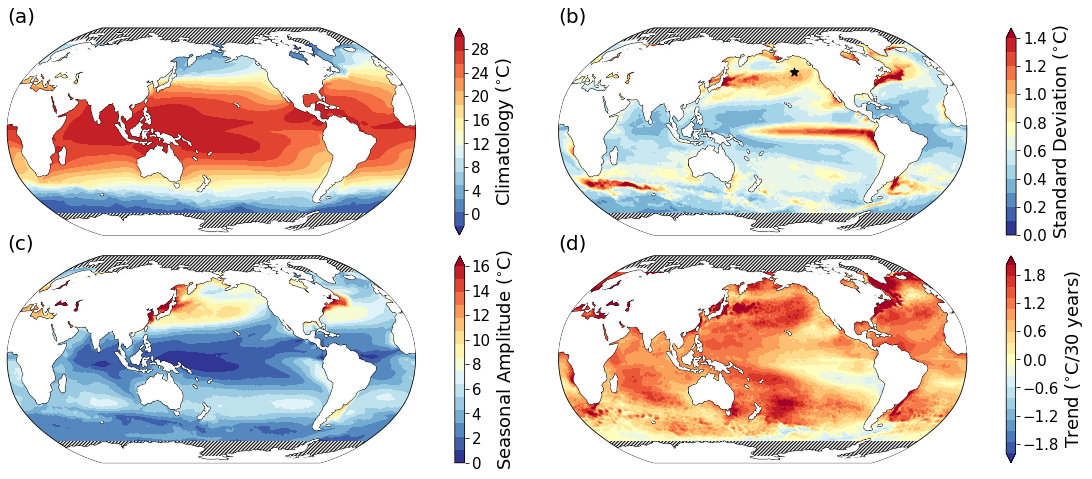

In [116]:
fig = plt.figure(figsize=(24,8))

# 1a
# Global distribution of (a) mean ( SSTm)SSTm computed with respect to September 1981 through January 2021. 
# Hatching over the polar oceans represent regions that are excluded from this analysis.
ax = plt.subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('(a)', loc='left', fontsize=20)
im = SSTm_nopoles.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=-2, vmax=30, levels=15,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='RdYlBu_r') # cmocean.cm.balance
cb = plt.colorbar(im, ticks=[0, 4, 8, 12, 16, 20, 24, 28])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Climatology ($\rm^{\circ}$C)', size=18)
newnew.plot.contourf(transform=ccrs.PlateCarree(), 
                     extend='both', 
                     add_colorbar=False, 
                     add_labels=False, 
                     hatches=['///////'], 
                     cmap='Greys_r',
                     vmin=0,vmax=1)
ax.add_feature(cfeature.LAND, facecolor='w', zorder=50); ax.coastlines(resolution='110m', color='black', linewidth=2)

# 1b
# Global distribution of (b)  standard deviation of the anomalies detrended (SSTa)
# computed with respect to September 1981 through January 2021. 
# Hatching over the polar oceans represent regions that are excluded from this analysis.
ax = plt.subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('(b)', loc='left', fontsize=20)
im = ssta_notrend_std_nopoles.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax=1.4, levels=15,
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               cmap='RdYlBu_r') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Standard Deviation ($\rm^{\circ}$C)', size=18)

newnew.plot.contourf(transform=ccrs.PlateCarree(),
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               hatches=['///////'],
                cmap='Greys_r',vmin=0,vmax=1)
ax.add_feature(cfeature.LAND, facecolor='w', zorder=50); ax.coastlines(resolution='110m', color='black', linewidth=2)
ax.scatter(abs(148.875-360), 46.625, marker='*',s=80,c='k',transform=ccrs.PlateCarree())

# 1c
# Global distribution of (c) amplitude of the seasonal cycle (SSTs) as the peak minus the trough
# computed with respect to September 1981 through January 2021. 
# Hatching over the polar oceans represent regions that are excluded from this analysis.
ax = plt.subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('(c)', loc='left', fontsize=20)
im = seas_amp.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax=16, levels=16,
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               cmap='RdYlBu_r') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Seasonal Amplitude ($\rm^{\circ}$C)', size=18)

newnew.plot.contourf(transform=ccrs.PlateCarree(),
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               hatches=['///////'],
                cmap='Greys_r',vmin=0,vmax=1)
ax.add_feature(cfeature.LAND, facecolor='w', zorder=50); ax.coastlines(resolution='110m', color='black', linewidth=2)

# figure 1d
ax = plt.subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('(d)', loc='left', fontsize=20)
im = trend_30yrs_nopoles.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=-2, vmax=2, levels=18,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='RdYlBu_r') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[-1.8, -1.2, -0.6, 0.0, 0.6, 1.2, 1.8])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Trend ($\rm^{\circ}$C/30 years)', size=18)

newnew.plot.contourf(transform=ccrs.PlateCarree(),
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               hatches=['///////'],
                cmap='Greys_r',vmin=0,vmax=1)
ax.add_feature(cfeature.LAND, facecolor='w', zorder=50); ax.coastlines(resolution='110m', color='black', linewidth=2)

plt.subplots_adjust(wspace=-0.3, hspace=0.1)
plt.savefig('Figure1.jpeg')
plt.show()

#### Figure 1
Figure 1. Global distribution of (a) mean ( SSTm)SSTm, (b) standard deviation of the anomalies detrended (SSTa), (c) amplitude of the seasonal cycle (SSTs) as the peak minus the trough, and (d) the 30-year trend (SSTt) from 1990 through 2020. Maps in (a-c) have means computed with respect to September 1981 through January 2021. Hatching over the polar oceans represent regions that are excluded from this analysis. 

In [117]:
sst_fit = model_da.dot(sst_mod)
sst_a = ssta_notrend
sst_a_star = ssta_stn_notrend

In [118]:
threshold_90_val = sst_a_star.sel(lon=abs(148.875-360), lat=46.625, method='nearest').quantile(0.9, dim='time')

In [119]:
sst_fit_atpt = sst_fit.sel(lon=abs(148.875-360), lat=46.625, method='nearest').sel(time=slice("2010-01-01", "2021-01-01"))
sst_atpt = sst.sel(lon=abs(148.875-360), lat=46.625, method='nearest').sel(time=slice("2010-01-01", "2021-01-01"))
sst_a_atpt = sst_a.sel(lon=abs(148.875-360), lat=46.625, method='nearest').sel(time=slice("2010-01-01", "2021-01-01"))
sst_a_star_atpt = sst_a_star.sel(lon=abs(148.875-360), lat=46.625, method='nearest').sel(time=slice("2010-01-01", "2021-01-01"))

In [120]:
red_dots_where = np.where(sst_a_star_atpt > threshold_90_val)
sst_a_star_atpt[red_dots_where]

<xarray.DataArray (time: 22)>
array([1.72891676, 1.86800214, 2.92439438, 2.83290644, 2.01437968,
       1.72630149, 1.95489385, 1.78588067, 1.6823964 , 1.49093876,
       2.34959532, 2.38374103, 1.64996938, 1.39670762, 1.59990547,
       1.50643042, 1.38891929, 1.47151627, 2.40299289, 2.69684042,
       1.55574788, 1.73045453])
Coordinates:
    lat      float32 46.62
    lon      float32 211.1
  * time     (time) datetime64[ns] 2010-08-01 2013-11-01 ... 2020-07-01
    month    (time) int64 8 11 12 1 2 4 5 6 9 6 8 9 5 6 7 8 11 12 4 5 6 7

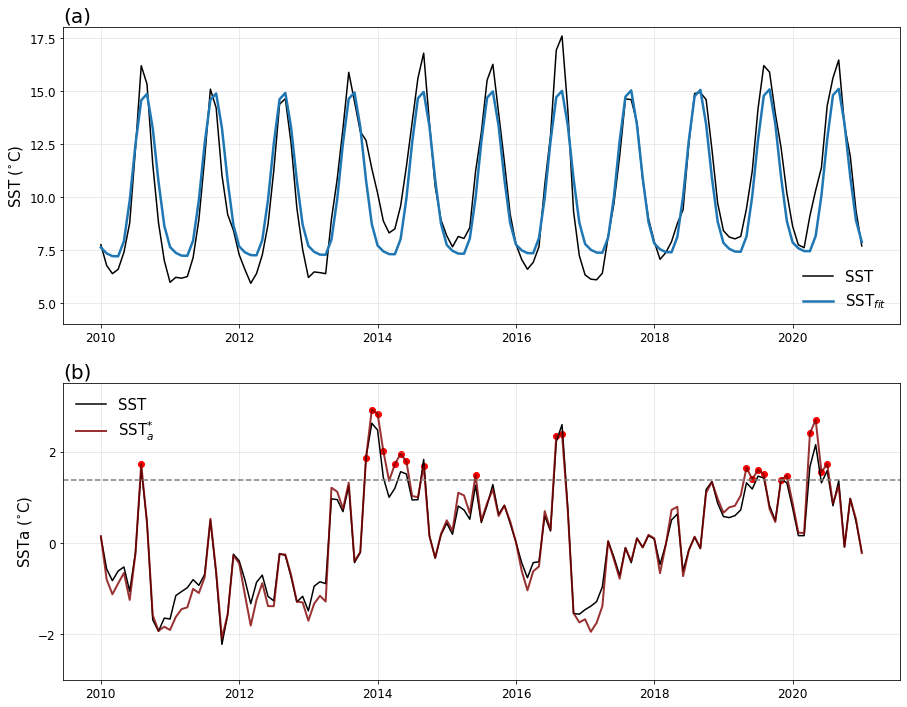

In [121]:
fig = plt.figure(figsize=(15,12))

plt.subplot(2,1,1)
plt.title('(a)', loc='left', fontsize=20)
plt.ylim(4, 18)
plt.plot(sst_atpt, c='k',label='SST')
plt.plot(sst_fit_atpt, c='tab:blue',linewidth=2.5, label='SST$_{fit}$')
plt.legend(frameon=False,fontsize=15)
plt.ylabel(r'SST ($\rm^{\circ}$C)',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks([0,24,48,72,96,120],[2010,2012,2014,2016,2018,2020], rotation='horizontal', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2,1,2)
plt.title('(b)', loc='left', fontsize=20)
plt.ylim(-3, 3.5)
plt.plot(sst_a_atpt, c='k',label='SST')
plt.plot(sst_a_star_atpt, c='maroon',linewidth=2, label='SST$_{a}^{ *}$',alpha=0.8)
plt.scatter(red_dots_where, sst_a_star_atpt[red_dots_where], c='red')
plt.legend(frameon=False,fontsize=15)
plt.axhline(y=threshold_90_val, c='grey',linestyle='dashed')
plt.ylabel(r'SSTa ($\rm^{\circ}$C)',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks([0,24,48,72,96,120],[2010,2012,2014,2016,2018,2020], rotation='horizontal', fontsize=12)
plt.grid(alpha=0.3)

plt.subplots_adjust(wspace=-0.3, hspace=0.2)
plt.savefig('Figure2.jpeg')
plt.show()

#### Figure 2
Figure 2. Monthly time series of (a) SST and (b) SSTa from January 2010 through January 2021 at 46.625ºS, 148.875ºW (star in Figure 1b). The mean, seasonal cycle, and trend in SST are shown in (a) as SSTfit. SSTa in (b) is defined as SST minus SSTfit. The standardized SSTa* is shown in red and has been divided by its monthly standard deviation. Red circles indicate when the SSTa* exceeded the 90th percentile of SSTa* (shown by the dashed line) computed over the entire period from September 1981 through January 2021.

In [122]:
ds = ds.sel(lat=slice(-65, 70))

In [123]:
features_notrend = features_notrend.sel(lat=slice(-65, 70))
print(features_notrend.shape)
ssta_notrend = ssta_notrend.sel(lat=slice(-65, 70))
print(ssta_notrend.shape)
sst = sst.sel(lat=slice(-65, 70))
print(sst.shape)
stdev = stdev.sel(lat=slice(-65, 70))

(473, 540, 1440)
(473, 540, 1440)
(473, 540, 1440)


In [ ]:
# Add a land/ocean mask
mask = np.isfinite(sst.isel(time=0))

# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        features_notrend=(['time','lat','lon'], features_notrend.values),
        ssta_notrend=(['time','lat','lon'], ssta_notrend.values),
        stdev=(['month','lat','lon'], stdev.values),
        mask=(['lat','lon'], mask.values),
    ),
    coords=dict(
        lon=ds.lon,
        lat=ds.lat,
        time=ds.time[:473],
        month=stdev.month,
    ),
    attrs=dict(description="OISST v2.1 preprocessed for Ocetrac",
              threshold='90th percentile',
              climatology='entire period'),
)
ds_out

In [ ]:
ds_out.to_netcdf('01_preprocess_01_nopoles.nc', mode='w')

### Use Ocetrac to identify and track marine heatwaves

In [124]:
ds = xr.open_dataset('01_preprocess_01_nopoles.nc', engine='netcdf4')

In [ ]:
%%time 
features = ds.features_notrend
features.load()

In [ ]:
# Binary conversion
binary_out = np.isfinite(features)
binary_out.isel(time=0).plot()

In [ ]:
mask = ds.mask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 
mask.plot()

In [ ]:
mask = ds.mask.where((ds.lat>-65) & (ds.lat<70), drop=False, other=0) 
mask.plot()

In [ ]:
%%time
Tracker = ocetrac.Tracker(binary_out, mask, radius=8, min_size_quartile=0.75, timedim='time', xdim='lon', ydim='lat', positive=True)
blobs = Tracker.track()

In [ ]:
blobs.to_netcdf('02_blobs_nopoles_newmask.nc', mode='w')

In [125]:
blobs = xr.open_dataset('02_blobs_nopoles_newmask.nc', engine='netcdf4')

In [127]:
# blobs.attrs

In [ ]:
# combined labels with SSTA
ssta_notrend_nopoles = ssta_notrend_nopoles.sel(lat=slice(-65, 70)) 
ssta_notrend_nopoles.name = 'SSTA'
events_file = xr.merge([ssta_notrend_nopoles, blobs])

In [ ]:
# events_file.to_netcdf('saved_on_disk.nc')

### Analysis

In [128]:
events_file = xr.open_dataset('saved_on_disk.nc', engine='netcdf4')

In [129]:
events_file

<xarray.Dataset>
Dimensions:  (lat: 540, lon: 1440, time: 473)
Coordinates:
  * lat      (lat) float32 -64.88 -64.62 -64.38 -64.12 ... 69.38 69.62 69.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-01-01
Data variables:
    SSTA     (lat, time, lon) float64 ...
    labels   (time, lat, lon) float64 ...

In [134]:
no_mhws = number_of_mhws(events_file)
print(no_mhws)

813


In [ ]:
%%time
duration = Parallel(n_jobs=32, require="sharedmem")(delayed(calc_duration)(events_file, mhw_id) for mhw_id in list(range(1,no_mhws+1)))

In [ ]:
with open('duration.pkl', 'wb') as f:
    pickle.dump(duration, f)

In [ ]:
%%time
max_intensity = Parallel(n_jobs=32, require="sharedmem")(delayed(calc_maximum_intensity)(events_file, mhw_id) for mhw_id in list(range(1,no_mhws+1)))

In [ ]:
with open('max_intensity.pkl', 'wb') as f:
    pickle.dump(max_intensity, f)

In [ ]:
%%time
spatial_extent = Parallel(n_jobs=32, require="sharedmem")(delayed(calc_spatial_extent)(events_file, mhw_id) for mhw_id in list(range(1,no_mhws+1)))

In [ ]:
with open('spatial_extent.pkl', 'wb') as f:
    pickle.dump(spatial_extent, f)

In [16]:
%%time
initial_state = Parallel(n_jobs=32, require="sharedmem")(delayed(get_initial_state)(events_file, mhw_id) for mhw_id in list(range(1,no_mhws+1)))

CPU times: user 29min 14s, sys: 1h 20min 15s, total: 1h 49min 30s
Wall time: 34min 36s


In [17]:
with open('first_timestep_save.pkl', 'wb') as f:
    pickle.dump(initial_state, f)

#### Metrics

In [137]:
duration = pd.read_pickle(r'duration.pkl')
max_intensity = pd.read_pickle(r'max_intensity.pkl')
spatial_extent = pd.read_pickle(r'spatial_extent.pkl')
first_timestep_save_ = pd.read_pickle(r'first_timestep_save.pkl')

In [138]:
print('duration mean:', np.nanmean(duration))
print('duration min:', np.nanmin(duration))
print('duration max:', np.nanmax(duration))

duration mean: 2.993849938499385
duration min: 1
duration max: 60


In [139]:
max_intensity_vals = np.zeros(len(max_intensity))
for i in range(len(max_intensity)):
    max_intensity_vals[i] = max_intensity[i][0].item()

In [141]:
print('max intensity mean:', np.nanmean(max_intensity_vals))
print('max intensity min:', np.nanmin(max_intensity_vals))
print('max intensity max:', np.nanmax(max_intensity_vals))

max intensity mean: 2.545483596812641
max intensity min: 0.19832182313586522
max intensity max: 9.110182732631042


In [142]:
max_spatial_extent_vals = np.zeros(len(spatial_extent))
mean_spatial_extent_vals = np.zeros(len(spatial_extent))
cumulative_spatial_extent_vals = np.zeros(len(spatial_extent))

for i in range(len(spatial_extent)):
    max_spatial_extent_vals[i] = spatial_extent[i]['max_spatial_extent'].item()
    mean_spatial_extent_vals[i] = spatial_extent[i]['mean_spatial_extent'].item()
    cumulative_spatial_extent_vals[i] = spatial_extent[i]['cumulative_spatial_extent'].item()

In [143]:
print('cumulative spat ext mean:', np.nanmean(cumulative_spatial_extent_vals))
print('cumulative spat ext min:', np.nanmin(cumulative_spatial_extent_vals))
print('cumulative spat ext max:',np.nanmax(cumulative_spatial_extent_vals))

cumulative spat ext mean: 317071348.9088324
cumulative spat ext min: 14687354.77125358
cumulative spat ext max: 28849170680.729248


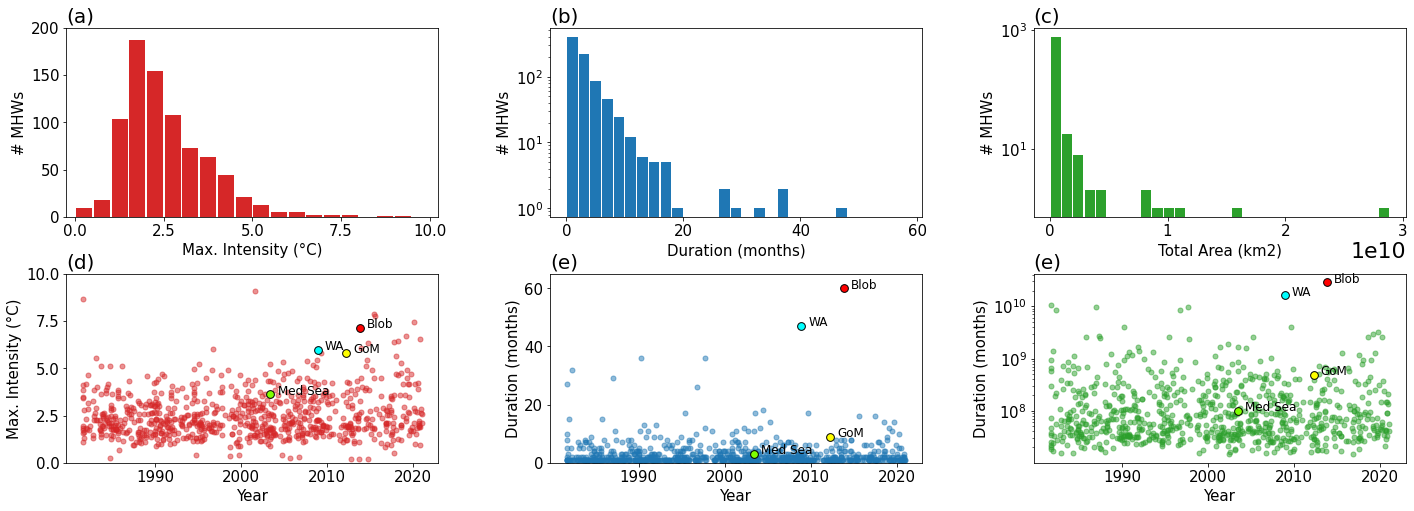

In [144]:
fig = plt.figure(figsize=(24,8))

plt.subplot(2,3,1)
plt.title('(a)', loc='left', fontsize=20)
plt.hist(max_intensity_vals, rwidth=0.9,bins=np.arange(0,10,0.5),color='tab:red')
plt.xlim(-0.25,10.25)
plt.ylim(0,200)
plt.xlabel('Max. Intensity (°C)', fontsize=15)
plt.ylabel('# MHWs', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,2)
plt.title('(b)', loc='left', fontsize=20)
plt.hist(duration,bins=np.arange(0,60,2),rwidth=0.9,color='tab:blue')
plt.yscale('log')
plt.xlabel('Duration (months)', fontsize=15)
plt.ylabel('# MHWs', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,3)
plt.title('(c)', loc='left', fontsize=20)
plt.hist(cumulative_spatial_extent_vals,rwidth=0.9,bins=30,color='tab:green')
plt.yscale('log')
plt.xlabel('Total Area (km2)', fontsize=15)
plt.ylabel('# MHWs', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,4)
plt.title('(d)', loc='left', fontsize=20)
plt.scatter(first_timestep_save_, max_intensity_vals,s=25,alpha=0.5,c='tab:red')
plt.ylim(0,10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Max. Intensity (°C)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks([100, 220, 340, 460],[1990,2000,2010,2020], rotation='horizontal', fontsize=15)

plt.scatter(first_timestep_save_[691],max_intensity_vals[691],c='red', edgecolor='black',s=60) # blob
plt.scatter(first_timestep_save_[650],max_intensity_vals[650],c='yellow', edgecolor='black',s=60) # gom
plt.scatter(first_timestep_save_[605],max_intensity_vals[605],c='aqua', edgecolor='black',s=60) # wa
plt.scatter(first_timestep_save_[463],max_intensity_vals[463],c='chartreuse', edgecolor='black',s=60) # medsea
plt.annotate('Blob', (first_timestep_save_[691]+10,max_intensity_vals[691]),fontsize=12)
plt.annotate('GoM', (first_timestep_save_[650]+10,max_intensity_vals[650]),fontsize=12)
plt.annotate('WA', (first_timestep_save_[605]+10,max_intensity_vals[605]),fontsize=12)
plt.annotate('Med Sea', (first_timestep_save_[463]+10,max_intensity_vals[463]),fontsize=12)

plt.subplot(2,3,5)
plt.title('(e)', loc='left', fontsize=20)
plt.scatter(first_timestep_save_, duration,s=25,alpha=0.5,c='tab:blue')
plt.ylim(0,65)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Duration (months)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks([100, 220, 340, 460],[1990,2000,2010,2020], rotation='horizontal', fontsize=15)

plt.scatter(first_timestep_save_[691],duration[691],c='red', edgecolor='black',s=60) # blob
plt.scatter(first_timestep_save_[650],duration[650],c='yellow', edgecolor='black',s=60) # gom
plt.scatter(first_timestep_save_[605],duration[605],c='aqua', edgecolor='black',s=60) # wa
plt.scatter(first_timestep_save_[463],duration[463],c='chartreuse', edgecolor='black',s=60) # medsea
plt.annotate('Blob', (first_timestep_save_[691]+10,duration[691]),fontsize=12)
plt.annotate('GoM', (first_timestep_save_[650]+10,duration[650]),fontsize=12)
plt.annotate('WA', (first_timestep_save_[605]+10,duration[605]),fontsize=12)
plt.annotate('Med Sea', (first_timestep_save_[463]+10,duration[463]),fontsize=12)

plt.subplot(2,3,6)
plt.title('(f)', loc='left', fontsize=20)
plt.title('(e)', loc='left', fontsize=20)
plt.scatter(first_timestep_save_, cumulative_spatial_extent_vals,s=25,alpha=0.5,c='tab:green')
# plt.ylim(0,65)
plt.yscale('log')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Duration (months)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks([100, 220, 340, 460],[1990,2000,2010,2020], rotation='horizontal', fontsize=15)

plt.scatter(first_timestep_save_[691],cumulative_spatial_extent_vals[691],c='red', edgecolor='black',s=60) # blob
plt.scatter(first_timestep_save_[650],cumulative_spatial_extent_vals[650],c='yellow', edgecolor='black',s=60) # gom
plt.scatter(first_timestep_save_[605],cumulative_spatial_extent_vals[605],c='aqua', edgecolor='black',s=60) # wa
plt.scatter(first_timestep_save_[463],cumulative_spatial_extent_vals[463],c='chartreuse', edgecolor='black',s=60) # medsea
plt.annotate('Blob', (first_timestep_save_[691]+10,cumulative_spatial_extent_vals[691]),fontsize=12)
plt.annotate('GoM', (first_timestep_save_[650]+10,cumulative_spatial_extent_vals[650]),fontsize=12)
plt.annotate('WA', (first_timestep_save_[605]+10,cumulative_spatial_extent_vals[605]),fontsize=12)
plt.annotate('Med Sea', (first_timestep_save_[463]+10,cumulative_spatial_extent_vals[463]),fontsize=12)

plt.savefig('Figure7.jpeg')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#### Figure 7
Figure 7. Distribution of (a) maximum intensity (mean=2.55ºC, min.=0.20ºC, max.=9.11ºC), (b) duration (mean=2.99 months, minimum=1 month, maximum=60 months), and (c) total area (mean=3.17x10$^{8}$ km$^{2}$, minimum=1.47x10$^{7}$ km$^{2}$, maximum=2.88x10$^{10}$ km$^{2}$) for 813 MHWs detected between September 1981 through January 2021. MHWs are identified from the ¼º resolution OISSTv2 and defined when the detrended SST exceeds the local monthly averaged 90th percentile. MHWs have been smoothed with a 8 grid spacing morphological radius and only events that exceed the 75th percentile (1.85x106 km$^{2}$) of the initial areal distribution are considered. Named MHW are indicated by the colored dots using definitions in Table 3.

### Case Studies

In [ ]:
# Northeast Pacific 'The Blob' is id = 692
checktheseindices = np.unique(blobs.labels.sel(time=slice('07-01-2013', '11-01-2017')))
for i in checktheseindices:
    event = blobs.labels.where(blobs.labels==i, drop=True)
    print(i, event.shape)

In [ ]:
# Gulf of Maine is id = 651
checktheseindices = np.unique(events_file.labels.sel(time=slice('01-01-2012', '12-01-2012')))
for i in checktheseindices:
    event = events_file.labels.where(events_file.labels==i, drop=True)
    print(i, event.shape)

In [ ]:
# West Coast of Australia is id = 606
checktheseindices = np.unique(blobs.labels.sel(time=slice('01-01-2009', '12-01-2013')))
for i in checktheseindices:
    event = blobs.labels.where(blobs.labels==i, drop=True)
    print(i, event.shape)

In [ ]:
# Mediterranean Sea is id = 464
checktheseindices = np.unique(blobs.labels.sel(time=slice('01-01-2003', '12-01-2003'),lon=slice(0,100)))
for i in checktheseindices:
    event = blobs.labels.where(blobs.labels==i, drop=True)
    print(i, event.shape)

In [14]:
# need to subtract one from the actual ocetrac label
# check measure statistics of The Blob ID = 691, 692
print(max_intensity_vals[691])
print(cumulative_spatial_extent_vals[691])
print(duration[691])
print(mean_spatial_extent_vals[691])
print(max_spatial_extent_vals[691])

7.128388277631833
28849170680.729248
60
480819511.3454875
1502729175.5516565


In [17]:
# GoM ID = 650, 651
print(max_intensity_vals[650])
print(cumulative_spatial_extent_vals[650])
print(duration[650])
print(mean_spatial_extent_vals[650])
print(max_spatial_extent_vals[650])

5.815049810081706
494279363.3440262
9
54919929.26044735
102511105.57179219


In [15]:
# WA ID = 605, 606
print(max_intensity_vals[605])
print(cumulative_spatial_extent_vals[605])
print(duration[605])
print(mean_spatial_extent_vals[605])
print(max_spatial_extent_vals[605])

5.964656242139409
16233449037.496628
47
345392532.7126941
697820569.9857633


In [16]:
# Med Sea = 463, 464
print(max_intensity_vals[463])
print(cumulative_spatial_extent_vals[463])
print(duration[463])
print(mean_spatial_extent_vals[463])
print(max_spatial_extent_vals[463])

3.622504998506294
99048921.44599016
3
33016307.148663387
37632124.313656636


In [146]:
merged_xarray = events_file
one_obj = merged_xarray.where(merged_xarray.labels==692, drop=True) #651 #692 #606, #464

In [147]:
print(one_obj.SSTA.mean().item())
print(one_obj.SSTA.sum().item())

0.9844130754194045
2825269.4641059926


#### Centroids

In [149]:
# let's find the number of centroids
forOneMHW_labels_only = extract_mhw_labels(merged_xarray, 692)

In [150]:
num_centroids = []
for i in range(len(forOneMHW_labels_only[:,0,0])):
    num_centroids.append(len(centroids_per_timestep(forOneMHW_labels_only, i)))

[1, 1, 1, 1, 2, 1, 2, 3, 4, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 4, 5, 4, 5, 4, 7, 6, 6, 7, 5, 4, 4, 5, 6, 5, 6, 6, 6, 4, 5, 4, 4, 4, 3, 4, 5, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1]


In [151]:
print(np.sum(num_centroids))
print(np.nanmax(num_centroids))

195
7


In [156]:
# just some statistics about the longest htw (this is The Blob)
max_duration_id = np.argmax(np.asarray(duration)) + 1
print(max_duration_id+1)
max_duration = np.max(np.asarray(duration))
print(max_duration)

max_dur_htw = blobs.where(blobs.labels==max_duration_id, drop=True)
max_dur_htw

693
60


<xarray.Dataset>
Dimensions:  (time: 60, lat: 540, lon: 1440)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -64.88 -64.62 -64.38 -64.12 ... 69.38 69.62 69.88
  * time     (time) datetime64[ns] 2013-11-01 2013-12-01 ... 2018-10-01
Data variables:
    labels   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

#### Cumulative Intensity

In [157]:
# Northeast Pacific
NEPacific = events_file.where(events_file.labels==692, drop=False)
NEPacific_cumulativeintensity = NEPacific.sum(dim='time')
NEPacific_cumulativeintensity = xr.where(NEPacific_cumulativeintensity.SSTA == 0., np.nan, NEPacific_cumulativeintensity.SSTA)
print(np.nanmax(NEPacific_cumulativeintensity))

50.03403417601566


In [158]:
# Gulf of Maine
GOM = events_file.where(events_file.labels==651, drop=False)
GOMcumulativeintensity = GOM.sum(dim='time')
GOMcumulativeintensity = xr.where(GOMcumulativeintensity.SSTA == 0., np.nan, GOMcumulativeintensity.SSTA)
GOMcumulativeintensity = GOMcumulativeintensity.sel(lat=slice(15,85), lon=slice(250,360)) # for plotting purposes
print(np.nanmax(GOMcumulativeintensity))

21.151680656527923


In [159]:
# West Coast of Australia
WCA = events_file.where(events_file.labels==606, drop=False)
WCAcumulativeintensity = WCA.sum(dim='time')
WCAcumulativeintensity = xr.where(WCAcumulativeintensity.SSTA == 0., np.nan, WCAcumulativeintensity.SSTA)
print(np.nanmax(WCAcumulativeintensity))

33.44481167567495


In [160]:
# Mediterranean Sea
MedSea = events_file.where(events_file.labels==464, drop=False)
MedSeacumulativeintensity = MedSea.sum(dim='time')
MedSeacumulativeintensity = xr.where(MedSeacumulativeintensity.SSTA == 0., np.nan, MedSeacumulativeintensity.SSTA)
MedSeacumulativeintensity = MedSeacumulativeintensity.sel(lat=slice(25,55), lon=slice(0,60)) # for plotting purposes
print(np.nanmax(MedSeacumulativeintensity))

8.177908014101465


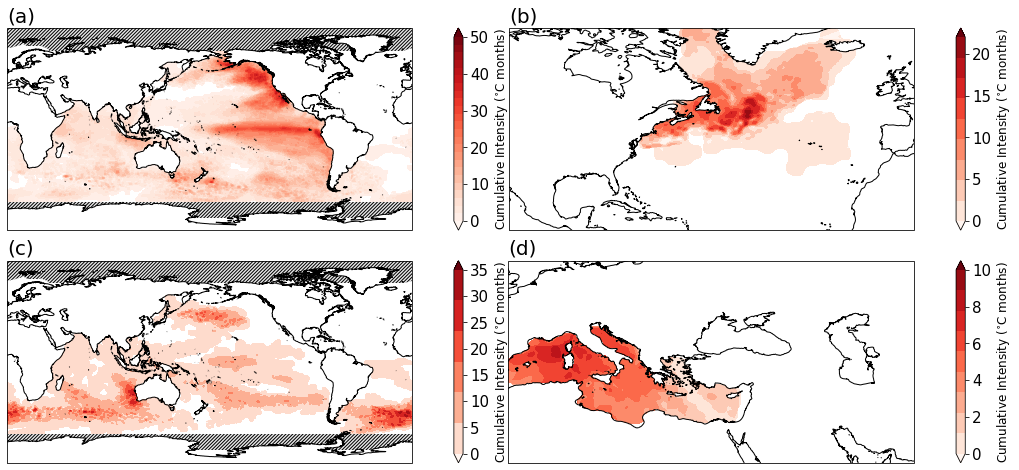

In [169]:
fig = plt.figure(figsize=(24,8))

ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.set_title('(a)', loc='left', fontsize=20)
ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=60)

im = NEPacific_cumulativeintensity.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax= 50, levels=25,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0,10,20,30,40,50])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Cumulative Intensity ($\rm^{\circ}$C months)', size=12)
newnew.plot.contourf(transform=ccrs.PlateCarree(),
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               hatches=['///////'],
                cmap='Greys_r',vmin=0,vmax=1)

ax = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.set_title('(b)', loc='left', fontsize=20)
ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=60)

im = GOMcumulativeintensity.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax= 22, levels=10,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0.0, 5.0, 10.0, 15.0, 20.0, 25.0])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Cumulative Intensity ($\rm^{\circ}$C months)', size=12)

ax = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.set_title('(c)', loc='left', fontsize=20)
ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=60)

im = WCAcumulativeintensity.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax= 35, levels=7,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0, 5, 10, 15, 20, 25, 30, 35])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Cumulative Intensity ($\rm^{\circ}$C months)', size=12)
newnew.plot.contourf(transform=ccrs.PlateCarree(),
               extend='max', 
               add_colorbar=False,
               add_labels=False,
               hatches=['///////'],
                cmap='Greys_r',vmin=0,vmax=1)

ax = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.set_title('(d)', loc='left', fontsize=20)
ax.coastlines(resolution='10m', color='black', linewidth=1,zorder=60)

im = MedSeacumulativeintensity.plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax=10,levels=10,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0, 2, 4, 6, 8,10])
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'Cumulative Intensity ($\rm^{\circ}$C months)', size=12)
plt.subplots_adjust(wspace=-0.4, hspace=0.15)

plt.savefig('Figure8.jpeg')
plt.show()

#### Figure 8
Figure 8. Spatiotemporal evolution of the cumulative intensity (°C-months) over the entire footprint of (a) the Northeast Pacific "Blob" (event \#692, 11/2012 to 10/2018), (b) the Gulf of Maine (event \#651, 04/2012 to 12/2012), (c) the Western Australia (event \#606, 12/2008 to 10/2012) and (d) the Mediterranean Sea (\#464, 06/2003 to 08/2003). Data are from the monthly 1/4° resolution OISSTv2 with the trend removed using a minimum area threshold of the 75th percentile and an edge detection radius of 8 grid spaces (approx. 2° latitude and longitude).

#### Evolution of GOM MHW

In [164]:
# let's try getting the first timestep 
print(first_timestep_save_[650])
print(duration[650])

367
9


In [165]:
GOM_SSTA = GOM.SSTA[:,first_timestep_save_[650]:first_timestep_save_[650]+duration[650],:]
GOM_SSTA = GOM_SSTA.sel(lat=slice(15,85), lon=slice(250,360)) # for plotting purposes

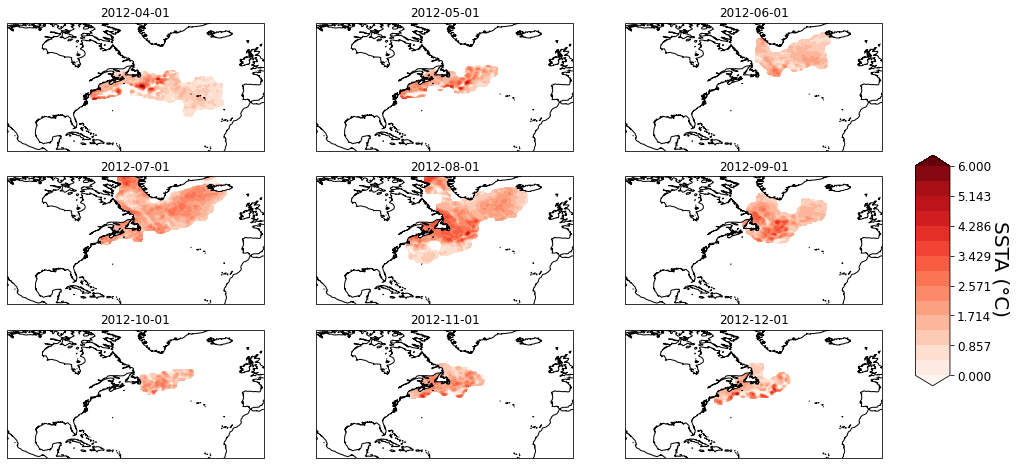

In [167]:
fig = plt.figure(figsize=(24,8))
for i in range(1,10):
    ax = plt.subplot(3,3,i, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
    ax.set_title(GOM_SSTA[:,i-1,:].time.values.astype('datetime64[D]'))
    ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=60)
    im = GOM_SSTA[:,i-1,:].plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax= 6, levels=15,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds')

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.8, 0.25, 0.02, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)
ax = cbar.ax
ax.text(13,1.8,'SSTA (°C)',rotation=270, fontsize=20)

plt.subplots_adjust(wspace=-0.6, hspace=0.2)
plt.savefig('Figure9.jpeg')
plt.show()

#### Figure 9
Figure 9. Spatiotemporal evolution of the SSTa (°C) over the entire footprint of the Gulf of Maine (event \#651).

#### Making Supplementary Materials

In [84]:
mhw_id = 464
event = events_file.where(events_file.labels==mhw_id, drop=True)
event

<xarray.Dataset>
Dimensions:  (lat: 58, time: 3, lon: 138)
Coordinates:
  * lat      (lat) float32 30.88 31.12 31.38 31.62 ... 44.38 44.62 44.88 45.12
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 33.62 33.88 34.12 34.38
  * time     (time) datetime64[ns] 2003-06-01 2003-07-01 2003-08-01
Data variables:
    SSTA     (lat, time, lon) float64 nan nan nan nan nan ... nan nan nan nan
    labels   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [85]:
event_intensity = events_file.SSTA.where((events_file.time==event.time), drop=False).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.labels.fillna(0)

In [97]:
# for plotting purposes
# event_intensity = event_intensity.sel(lat=slice(15,85), lon=slice(285,360)) # for Gulf of Maine Htw
# events_contour = events_contour.sel(lat=slice(15,85), lon=slice(285,360))

event_intensity = event_intensity.sel(lat=slice(25,55), lon=slice(0,60)) # for Mediterranean Sea Htw
events_contour = events_contour.sel(lat=slice(25,55), lon=slice(0,60))

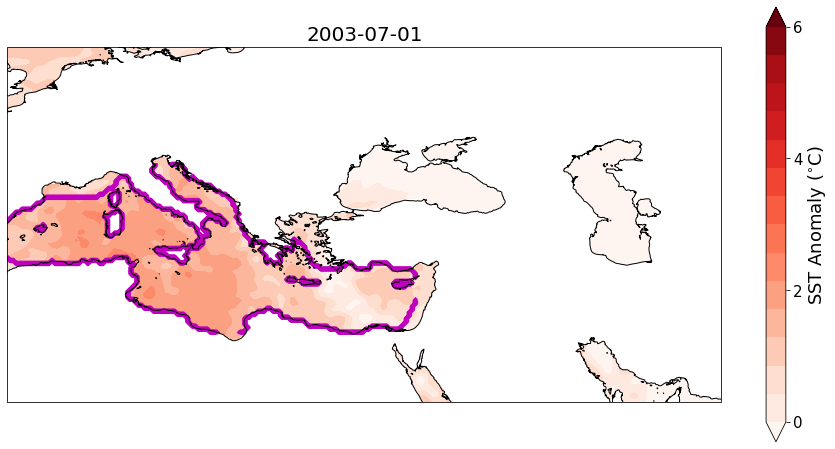

In [99]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)

fig = plt.figure(figsize=(16,8)) 

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.coastlines(resolution='10m', color='black', linewidth=1,zorder=60)
plt.title(event.isel(time=1).time.values.astype('datetime64[D]'),fontsize=20)

im = event_intensity.isel(time=1, intensity=0).plot.contourf(transform=ccrs.PlateCarree(),
               vmin=0, vmax=6,levels=15,
               extend='both', 
               add_colorbar=False,
               add_labels=False,
               cmap='Reds') # maybe choose a better colormap
cb = plt.colorbar(im, ticks=[0, 2, 4, 6, 8,10])
cb.ax.tick_params(labelsize=15)
events_contour.isel(time=1).plot.contour(transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)

cb.set_label(label=r'SST Anomaly ($\rm^{\circ}$C)', size=18)
plt.subplots_adjust(wspace=-0.4, hspace=0.15)

In [170]:
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc

IndexError: index 3 is out of bounds for axis 1 with size 3

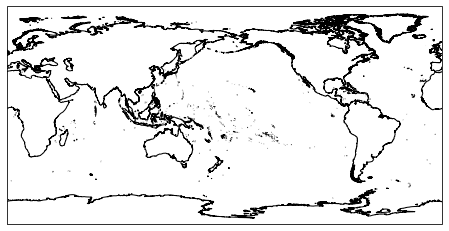

In [100]:
# Make animation
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(12,4)) 
plt.rcParams['animation.ffmpeg_path'] = '/glade/u/apps/dav/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'
plt.rcParams['animation.embed_limit'] = 2**128


ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.coastlines(resolution='110m', color='black', linewidth=1); ax.add_feature(cfeature.LAND, facecolor='w')
plt.title(event.isel(time=0).time.values.astype('datetime64[D]'))
im = event_intensity.isel(time=0, intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2, 
                                                  cmap='RdBu_r', extend='both', add_colorbar=False, 
                                                  add_labels=False)
cb = plt.colorbar(im); cb.set_label(label=r'SST Anomaly ($\rm^{\circ}$C)', size=18)
events_contour.isel(time=0).plot.contour(transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)
ax.set_global(); ax.clear()

def animate(c):
#         ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180, globe=None)); ax.clear()
#         # ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=180, globe=None)); ax.clear()
#         ax.coastlines(resolution='110m', color='black', linewidth=1); ax.add_feature(cfeature.LAND, facecolor='w')
#         plt.title(event.isel(time=c).time.values.astype('datetime64[D]'))
#         im = event_intensity.isel(time=c, intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2, 
#                                                   cmap='RdBu_r', extend='both', add_colorbar=False, 
#                                                   add_labels=False)
        
#         events_contour.isel(time=c).plot.contour(transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)
#         ax.set_global()
        ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
        ax.coastlines(resolution='10m', color='black', linewidth=1,zorder=60)
        plt.title(event.isel(time=c).time.values.astype('datetime64[D]'),fontsize=20)

        im = event_intensity.isel(time=c, intensity=0).plot.contourf(transform=ccrs.PlateCarree(),
                       vmin=-6, vmax=6,levels=20,
                       extend='both', 
                       add_colorbar=False,
                       add_labels=False,
                       cmap='RdBu_r') # maybe choose a better colormap
        cb = plt.colorbar(im, ticks=[-6,-4,-2,0,2,4,6])
        cb.ax.tick_params(labelsize=15)
        events_contour.isel(time=c).plot.contour(transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)

        cb.set_label(label=r'SST Anomaly ($\rm^{\circ}$C)', size=18)


anim = animation.FuncAnimation(fig, animate, frames=event.SSTA.shape[0])

# # Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
outpath = 'MedSea_event.mp4'
anim.save(outpath, writer=writer, dpi=300)
# HTML(anim.to_jshtml())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
outpath = '/glade/u/home/cassiacai/marine_heatwaves/mhw_event.mp4'
anim.save(outpath, writer=writer, dpi=300)
HTML(anim.to_jshtml())

### Functions

In [130]:
# from measures.py
import numpy as np
import xarray as xr
from skimage import img_as_float
from skimage.morphology import convex_hull_image
from skimage.measure import label as label_np, regionprops, find_contours
from scipy import ndimage
from scipy.interpolate import interp1d
from haversine import haversine, Unit
from typing import Dict, Optional, List, Tuple

def calc_duration(merged_xarray: xr.Dataset, mhw_id: int) -> int:
    """
    Calculate the duration of an object in the merged_xarray, i.e., the number of timesteps it appears in.

    Parameters
    ----------
    merged_xarray : xr.Dataset
        A dataset containing the object labels and data variables, including SSTA.
    mhw_id : int
        The identifier for the object.

    Returns
    -------
    int
        The number of timesteps where the object with the specified identifier appears in the merged_xarray.
    """
    return len(merged_xarray.where(merged_xarray.labels==mhw_id, drop=True).time)

def calc_maximum_intensity(merged_xarray: xr.Dataset, mhw_id: int) -> Tuple[float, xr.DataArray]:
    """
    Calculate the maximum intensity of the object for each timestep and over all its grid points.
    
    Parameters:
    -----------
    merged_xarray : xarray.Dataset
        An xarray dataset with data variables SSTA and labels
    mhw_id : int
        A specific object identifier
    
    Returns:
    --------
    Tuple of:
        - max_intensity: float
            Maximum intensity of the object over all its grid points and all timesteps
        - max_intensity_per_timestamp: xr.DataArray
            Maximum intensity of the object at each timestamp
    """
    one_obj = merged_xarray.where(merged_xarray.labels==mhw_id, drop=True)
    max_intensity = one_obj.max()
    max_intensity_per_timestamp = one_obj.SSTA.max(axis=(1,2))
    return max_intensity.SSTA, max_intensity_per_timestamp

def calc_spatial_extent(
    merged_xarray: xr.Dataset, 
    mhw_id: int, 
    coords_full: bool = False
):
    """
    Calculates the spatial extent of an object (area) in km2
    
    Parameters
    ----------
    merged_xarray : xarray.Dataset with data variables SSTA and labels
    mhw_id : specific object identifier
    coords_full : bool, optional
        If True, returns the full list of coordinates for each time step, by default False
    
    Returns
    -------
    dict
        Dictionary containing the following keys:
        - spatial_extents: List of areas for each time step in km
        - max_spatial_extent: Maximum area of the object in km2
        - max_spatial_extent_time: Time step when the object had the maximum area
        - mean_spatial_extent: Mean area of the object in km2
        - cumulative_spatial_extent: Cumulative area of the object in km2
        - coords_full (optional): List of coordinates for each time step
    """
    one_obj = merged_xarray.where(merged_xarray.labels == mhw_id, drop=True)
    
    spatial_extents = []
    coords_full_lst = []
    
    for i in range(len(one_obj.time)):
        for_onetimestep_stacked = one_obj.labels[i,:,:].stack(zipcoords=['lat','lon'])
        intermed = for_onetimestep_stacked[for_onetimestep_stacked.notnull()].zipcoords.values
        coords = list(map(tuple, intermed))
        coords_full_lst.append(coords)
        y, x = zip(*coords)
        # approximate conversions from https://en.wikipedia.org/wiki/Latitude
        dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]
        dlat = (110.574 *1) * np.ones(len(dlon))
        area = np.sum(dlon*dlat)
        spatial_extents.append(area)
    
    max_spatial_extent = max(spatial_extents)
    max_spatial_extent_time = np.argmax(spatial_extents)
    mean_spatial_extent = np.mean(spatial_extents)
    cumulative_spatial_extent = sum(spatial_extents)
    
    results = {
        "spatial_extents": spatial_extents,
        "max_spatial_extent": max_spatial_extent,
        "max_spatial_extent_time": int(max_spatial_extent_time),
        "mean_spatial_extent": mean_spatial_extent,
        "cumulative_spatial_extent": cumulative_spatial_extent,
    }
    
    if coords_full:
        results["coords_full"] = coords_full_lst
    
    return results

In [136]:
# from utils.py
def number_of_mhws(event_file) -> int:
    """
    Find the total number of objects in an event file
    Parameters
    ------------
    event_file : xarray.Dataset with data variables SSTA and labels
    Returns
    ------------
    Integer: total number of objects in an event file
    """
    return len(np.unique(event_file.labels)) - 1

def get_initial_state(merged_xarray: xr.Dataset, mhw_id: int):
    one_obj = merged_xarray.where(merged_xarray.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(one_obj.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    return first_timestep

In [133]:
def extract_mhw_labels(merged_xarray: xr.Dataset, mhw_id: int) -> xr.DataArray:
    """
    Extracts labels for a single marine heatwave (MHW) object and all its timesteps.
    
    Parameters
    ----------
    merged_xarray : xarray.Dataset
        A dataset containing the data variables SSTA and labels
    mhw_id : int
        The unique identifier of the MHW object.
        
    Returns
    -------
    xarray.DataArray
        A 3D array containing the labels for the specified MHW object and all its timesteps.
    """
    # Extract the MHW object
    one_obj = merged_xarray.where(merged_xarray.labels==mhw_id, drop=False)
    
    # Find the timesteps where the MHW object is present
    mhw_when = np.argwhere(one_obj.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    duration = calc_duration(merged_xarray, mhw_id)
    
    # Choose the timesteps where the MHW object is present and extract the labels
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    forOneMHW_only_timesteps = one_obj.labels[timesteps_to_choose_from,:,:]
    
    return forOneMHW_only_timesteps

def calc_centroids_per_timestep(extract_mhw_labels: xr.DataArray, timestep: int) -> list:
    """
    Finds the locations of the centroids of an object at each timestep.

    Parameters
    ----------
    extract_mhw_labels : xarray.DataArray
        A 3D array representing labels for each timestep of a single MHW object. The labels array is obtained using
        the `forOneMHW_labels_only` function in utils.py.
    timestep : int
        The index of the timestep for which centroids are to be computed.

    Returns
    -------
    list
        A list of (latitude, longitude) tuples representing the centroids of the MHW object at the specified timestep.

    Notes
    -----
    - There can be more than 1 centroid per object per timestep.
    - `forOneMHW_labels_only` function in utils.py should be run before calling this function.
    """
    sub_labels = extract_mhw_labels.isel(time=timestep)
    edge_labels = np.unique(np.concatenate((sub_labels[:,0].values, sub_labels[:,-1].values)))
    nonedge_labels = np.setdiff1d(np.unique(sub_labels.values), edge_labels)

    centroid_list = []
    for label in nonedge_labels:
        mask = (sub_labels == label)
        centroid_list.append(_get_centroids(mask))

    for left_label, right_label in zip(edge_labels[:-1], edge_labels[1:]):
        left_mask = (sub_labels == left_label)
        right_mask = (sub_labels == right_label)
        lon_edge = sub_labels.coords['lon'][0].item()

        # Shift left mask to the right and join with right mask
        shifted_left_mask = left_mask.roll(lon=-1)
        shifted_left_mask.coords['lon'] = (shifted_left_mask.coords['lon'] + 360) 
        joined_mask = shifted_left_mask.combine_first(right_mask)

        east_mask = joined_mask.where(joined_mask.lon > lon_edge, drop=True)
        west_mask = joined_mask.where(joined_mask.lon <= lon_edge, drop=True)
        new_mask = xr.concat([east_mask, west_mask], dim="lon")

        centroid_list.append(utils._get_centroids(new_mask))

    return list(set([item for sublist in centroid_list for item in sublist]))

def _get_centroids(sub_labels: xr.DataArray) -> List[Tuple[float, float]]:
    """
    Find the centroids of objects assigned to each unique label using skimage.measure.regionprops.

    Parameters
    ----------
    sub_labels : xarray.DataArray
        A 2D array of labels where each pixel is assigned a unique identifier. The array should have dimensions 
        ('latitude', 'longitude').

    Returns
    -------
    List[Tuple[float, float]]
        A list of tuples, where each tuple contains the latitude and longitude coordinates of the centroid of 
        each object. There may be more than one centroid per object per timestep.

    Notes
    -----
    The input sub_labels should be a 2D array. Because of the image transformation, any longitude coordinates
    greater than 360 degrees will be re-assigned to an appropriate coordinate between 0 and 360°.
    """
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    
    for i in range(len(centroids)):
        if centroids[i][1] >= 359.75:
            centroids[i] = (centroids[i][0], centroids[i][1] - 360.0)
    return centroids

In [145]:
def centroids_per_timestep(forOneMHW_onlylabels_timesteps, timestep):
    # Step 1. We start with one timestep and get all the sublabels
    timestep_of_interest = forOneMHW_onlylabels_timesteps[timestep,:,:]
    get_sub_lbs = timestep_of_interest
    sub_labels = _get_labels(get_sub_lbs)
    sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
    sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

    # Step 2. We get all the labels on the edges
    edge_right_sub_labels_ = sub_labels[:,-1:]
    edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
    edge_left_sub_labels_ = sub_labels[:,:1]
    edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])
    
    edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
    nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
    nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

    centroid_list = []
    for i in nonedgecases:
        sub_labels_nonedgecases = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
        centroid_list.append(_get_centroids(sub_labels_nonedgecases))
    for i in edge_left_sub_labels:
        sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
        lon_edge = sub_labels_left[:,-1:].lon.item()
        sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
        for j in edge_right_sub_labels:
            sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
            append_east_binarized = xr.where(append_east > 0, 1, np.nan)
            sub_labels = _get_labels(append_east_binarized)
            sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
            sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
            centroid_list.append(_get_centroids(sub_labels))
    flat_centroid_list = list(set([item for sublist in centroid_list for item in sublist])) # try saving as an xarray or data_array
    return flat_centroid_list

def _get_labels(binary_images):
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels